In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Gesture Recognition Training 

In [2]:

import pandas as pd
import numpy as np
import scipy.stats
import time
import multiprocessing as mp
import json
import random
import os
import random
import matplotlib.pyplot as plt
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

Loading BokehJS ...

In [3]:
# Redundent Random seed setting to ensure reproducible results  
random.seed(314)
np.random.seed(314)
tf.set_random_seed(314)

In [4]:
exists = os.path.isdir('data/demo4-training-data/')
if exists:
    print("Data directory already exists")
else:
    ! tar xzfv data/demo4-training-data.tar.gz --directory data

Data directory already exists


In [5]:
def read_data_into_dataframe(gesture_paths):
    
    examples = []
    for file in gesture_paths:
        with open(file) as f:
            opened_file = json.loads(f.read())
        
        examples.append(opened_file)
    
    examples = pd.io.json.json_normalize(examples)
    
    return examples 

In [6]:
path_to_data = "data/demo4-training-data/training-data"

list_of_gesture_path = []
for root, dirs, files in os.walk(path_to_data):
    for f in files:
        list_of_gesture_path.append(os.path.join(root, f))

then = time.time()
Data = read_data_into_dataframe(list_of_gesture_path)
print((time.time()-then)/60,"minutes")
print(len(Data), "records read...")

0.052995383739471436 minutes
878 records read...


In [7]:
def get_acceleration_data(df):
    re_arranged = []

    for row_index in range(len(Data)):

        x = [i[0] for i in df.iloc[row_index].motion]
        y = [i[1] for i in df.iloc[row_index].motion]
        z = [i[2] for i in df.iloc[row_index].motion]
        gesture = df.iloc[row_index].gesture

        entry = [x,y,z,gesture]
        re_arranged.append(entry)

    return pd.DataFrame(re_arranged, columns=["x","y","z","gesture"])
    

In [8]:
Acceleration_Data =  get_acceleration_data(Data)

In [9]:
def featurize(df_row, bins, columns):
    

    dimension_names = columns
    features = {}
    
    for ts, dim in zip(df_row,dimension_names):
        
        mean = np.mean(ts)
        median = np.median(ts)
        std = np.std(ts)
        length = len(ts)
        kurtosis = scipy.stats.kurtosis(ts)

        n, b = np.histogram(ts, 10)
        n = np.array(n)/float(np.sum(n)) #normalize i.e. fraction of entries in each bin

        if median == 0: 
            features[f'{dim}_mean_over_median'] =  0 #dimensionless            
            features[f'{dim}_std_over_median'] =  0 #dimensionless            
            features[f'{dim}_length'] = length
            features[f'{dim}_kurtosis'] = kurtosis #already dimensionless by definition
    

        else: 
            features[f'{dim}_mean_over_median'] =  mean/median #dimensionless            
            features[f'{dim}_std_over_median'] = std/median #dimensionless            
            features[f'{dim}_length'] = length
            features[f'{dim}_kurtosis'] = kurtosis #already dimensionless by definition


        for i, val in enumerate(n):
            features[f'{dim}_binfrac_{i}'] = val


        # new feature:
        midpoint = length//2
        ts_before = ts[:midpoint]
        ts_after = ts[midpoint:]

        mean_before = np.mean(ts_before) 
        mean_after = np.mean(ts_after)

        features[f'{dim}_mean_over_median_before'] = mean_before/median
        features[f'{dim}_mean_over_median_after'] = mean_after/median

        if length > 10:
            amp = np.fft.fft(ts)
            freq = np.fft.fftfreq(amp.size, 0.16)
            a_p = abs(amp.real[:1+len(amp)//2])
            f_p = freq[:1+len(freq)//2]

            max_power_index = np.argmax(abs(a_p[3:]))+3
            features[f'{dim}_max_power'] = abs(a_p[max_power_index])
            features[f'{dim}_period'] = f_p[max_power_index]
        else:
            features[f'{dim}_max_power'] = 0
            features[f'{dim}_period'] = 0


    features['label'] = df_row.gesture

    return features

In [10]:
then = time.time()
examples = [] 
b = np.arange(1,100,10)
columns = ["x","y","z"]
for i in Acceleration_Data.index:
    example = featurize(Acceleration_Data.iloc[i], b,columns)
    examples.append(example)
    
print((time.time()-then)/60,"minutes")
    

0.027335254351298015 minutes


In [11]:
df = pd.DataFrame(examples)

In [12]:
df = df[df["x_length"] > 200]
df = df.dropna()

In [13]:
train_df, test_df = train_test_split(df, train_size=0.75)

print(f'train size = {train_df.shape}')
print(f'test size = {test_df.shape}')

print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

train size = (614, 55)
test size = (205, 55)
shake            114
roll             114
fever            106
draw-triangle     98
draw-circle       98
floss             84
Name: label, dtype: int64
draw-triangle    40
draw-circle      36
roll             35
shake            33
floss            31
fever            30
Name: label, dtype: int64


In [14]:
train_label = np.array(train_df['label'])
test_label = np.array(test_df['label'])

label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=False,categories='auto')

train_integer = label_encoder.fit_transform(train_label)
train_onehot = one_hot_encoder.fit_transform(train_integer.reshape(len(train_integer), 1))

test_integer = label_encoder.transform(test_label)
test_onehot = one_hot_encoder.transform(test_integer.reshape(len(test_integer), 1))

In [15]:
model_1 = keras.Sequential([
    keras.layers.Dense(25, activation=tf.nn.relu, input_shape=(54,)),
    keras.layers.Dense(6, activation=tf.nn.log_softmax)
]) 

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
adm = tf.train.AdamOptimizer(learning_rate=1e-3)
model_1.compile(optimizer=adm, 
              loss=tf.losses.softmax_cross_entropy,
              metrics=['accuracy'])


Instructions for updating:
Use tf.cast instead.


In [17]:
history = model_1.fit( train_df.drop('label', axis=1), train_onehot, epochs=5000, verbose=0)

In [18]:
output_notebook()
p = figure()
p.line(np.linspace(1,5000,5000),history.history['acc'])
show(p)

Loading BokehJS ...

In [19]:
test_loss, test_acc = model_1.evaluate(test_df.drop('label', axis=1), test_onehot)

print('Test accuracy:', test_acc)

205/205 [==============================] - 0s 326us/sample - loss: 17.6462 - acc: 0.6439
Test accuracy: 0.6439024


Text(0, 0.5, 'predicted')

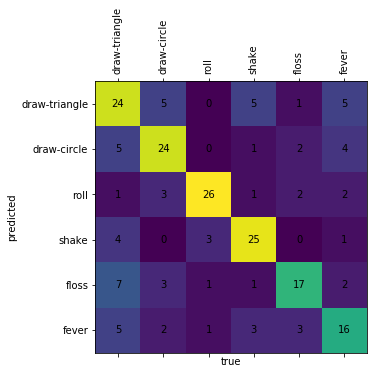

In [20]:
y_hat = model_1.predict(test_df.drop('label', axis=1))
y_hat = y_hat.argmax(axis=1)
y_hat = label_encoder.inverse_transform(y_hat)

fig = plt.figure(figsize=(5,5))
ax = plt.subplot()

labels = list(test_df['label'].value_counts().index)

confusion = confusion_matrix(test_label, y_hat, labels=labels)
ax.matshow(confusion)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels, rotation=90);
ax.set_yticklabels(labels);

for i in range(len(labels)):
    for j in range(len(labels)):        
        ax.text(j, i, confusion[i,j], va='center', ha='center')
        
plt.xlabel('true')
plt.ylabel('predicted')

In [21]:
print(classification_report(test_label, y_hat, labels=labels))

               precision    recall  f1-score   support

draw-triangle       0.52      0.60      0.56        40
  draw-circle       0.65      0.67      0.66        36
         roll       0.84      0.74      0.79        35
        shake       0.69      0.76      0.72        33
        floss       0.68      0.55      0.61        31
        fever       0.53      0.53      0.53        30

    micro avg       0.64      0.64      0.64       205
    macro avg       0.65      0.64      0.64       205
 weighted avg       0.65      0.64      0.65       205



In [22]:
test_set = test_df.drop('label', axis=1)
y = test_df.label.values

In [23]:
def confident_evaluation(X,y,model,label_encoder, threshold):
    
    feature_vectors = X.values 
    probabilities = model.predict_proba(feature_vectors)
    probabilities = pd.DataFrame(np.exp(probabilities))
    
    max_probability = pd.Series(np.max(probabilities, axis=1))
    gesture = probabilities.idxmax(axis=1)
    confident = pd.Series(max_probability >= threshold)
    
    accuracy = []
    unkown = []
    
    for prediction in confident.index:
        
        if confident[prediction] == True:
            predicted_gesture = label_encoder.inverse_transform([gesture[prediction]])[0]
            if predicted_gesture == y[prediction]:
                accuracy.append(1)
            else:
                accuracy.append(0)

        else:
            unkown.append(1)
        

    print("\nNumber of confident gestures: ", len(accuracy))
    
    print("Confident accuracy: ", float(sum(accuracy))/len(accuracy))
    
    print("Number of unknown gestures: ", len(unkown))
    
    print("Model was not confident about", len(unkown)/len(y)*100, "percent of data")
        

In [24]:
confident_evaluation(test_df.drop('label',axis=1), y, model_1 ,label_encoder, 0.85)


Number of confident gestures:  158
Confident accuracy:  0.7088607594936709
Number of unknown gestures:  47
Model was not confident about 22.926829268292686 percent of data


In [ ]:
# Save model for serving

In [ ]:
import os
from pathlib import Path
from datetime import datetime as dt

save = False
ver = int(dt.now().timestamp())

if save:
    for fmt in ['pb', 'hdf5', 'json']:
        # save model as hdf5
        MODEL_DIR = f"models/{fmt}"
        export_path = Path(MODEL_DIR, str(ver))

        if fmt == 'pb':
            # simple_save can not handle existing repository
            !rm -r {export_path}

            # Inspired by https://www.tensorflow.org/serving/tutorials/Serving_REST_simple
            # to save model for TF-serving
            tf.saved_model.simple_save(
                tf.keras.backend.get_session(),
                str(export_path),
                inputs={'input_data': model.input},
                outputs={t.name:t for t in model.outputs})
            
        elif fmt == 'hdf5':
            # make sure directory exists
            os.makedirs(export_path, exist_ok=True)
            
            model_path = Path(export_path, 'saved_model.h5') 
            
            # hdf5
            model.save(model_path)
            
        else:
            # make sure directory exists
            os.makedirs(export_path, exist_ok=True)
            
            # json
            model_spec_path = Path(
                export_path, 'saved_model_spec.json'
            )
            model_weights_path = Path(
                export_path, 'checkpoint')
            
            model_spec_path.write_text(model.to_json(), encoding='utf-8')
            model.save_weights(str(model_weights_path))

        print('\nSaved model:')
        !ls -l {export_path}